# Рекомендательная модель тарифов для клиентов телеком-компании

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»).  Предобработка данных не понадобится — она уже сделана в предыдущем курсе.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Импорт библиотек и загрузка данных

In [1]:
# Импортируем неоходимые библиотеки

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.dummy import DummyClassifier

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Откроем и изучим данные

df = pd.read_csv('C:/Users/Olga/datasets/users_behavior.csv')
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# Проверим соотношение значений в целевом столбце

df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

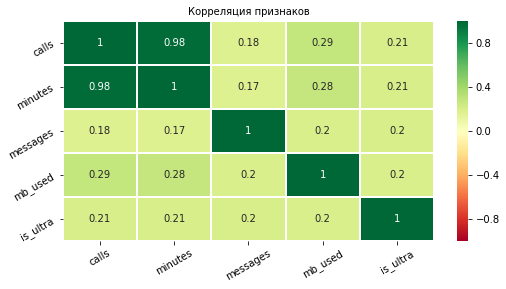

In [5]:
# Для проверки данных на мультиколлинеарность построим матрицу корреляций

f, ax = plt.subplots(figsize=(7,4))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap ='RdYlGn', linecolor='white', linewidths=1)
plt.title('Корреляция признаков', fontsize=10)
plt.subplots_adjust(top=1.5)
plt.tight_layout()
plt.xticks(rotation=30) 
plt.yticks(rotation=30)
ax.set_ylim(5, 0)
ax.set_xlim(0, 5)

plt.show()

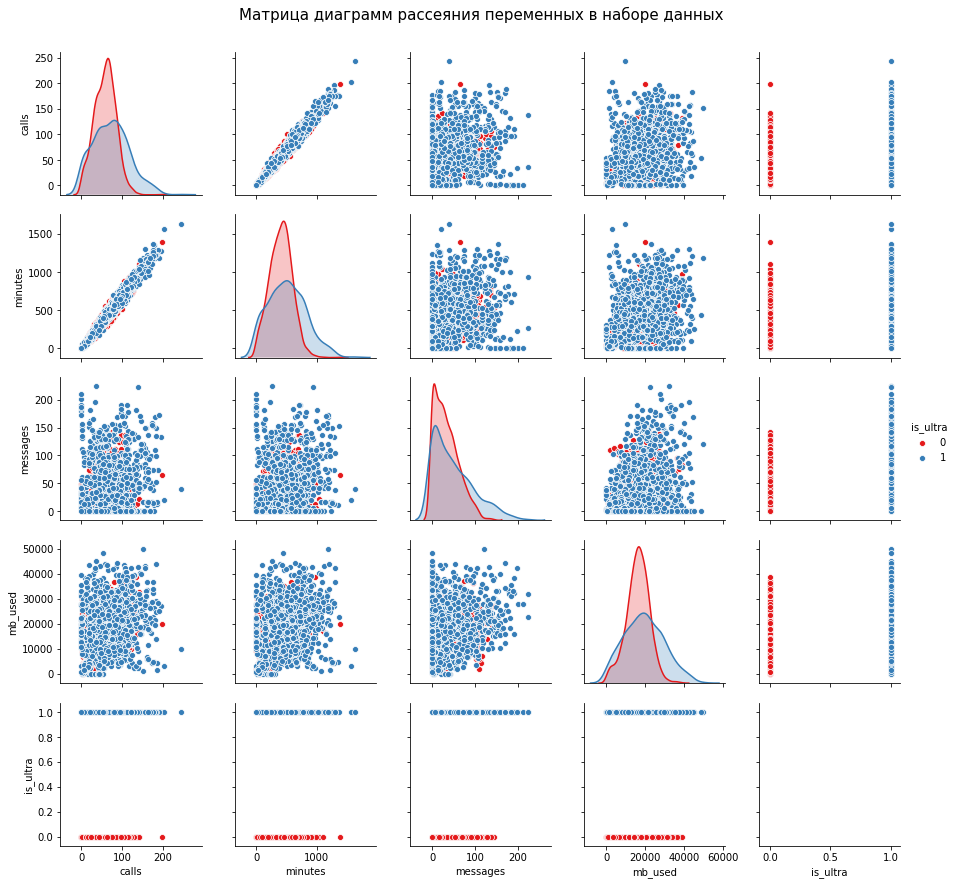

In [6]:
g = sns.pairplot(df, hue='is_ultra', palette='Set1')
g.fig.suptitle('Матрица диаграмм рассеяния переменных в наборе данных', fontsize=15)
plt.subplots_adjust(top=0.93)
plt.show()

**ВЫВОД:**

В данных обнаружена сильная корреляция в признаках calls и minutes. Чтобы избежать негативного эффекта мультиколлинеарности на линейные модели, необходимо удалить один из признаков при разделении на обучающую и тестовую выборки.


### Формирование выборок

In [7]:
# Разделим данные на обучающую и тестовую выборки. 
# Поскольку в целевом столбце наблюдается дисбаланс, применим параметр stratify при делении на выборки.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345, stratify=df['is_ultra'])

In [8]:
print("Исходный датасет:", df.shape)
print("Обучающая выборка:", df_train.shape,'что составляет', (len(df_train)/len(df)*100),'% от исходного датасета')
print("Тестовая выборка:", df_test.shape,'что составляет', (len(df_test)/len(df)*100),'% от исходного датасета' )

Исходный датасет: (3214, 5)
Обучающая выборка: (2571, 5) что составляет 79.99377722464219 % от исходного датасета
Тестовая выборка: (643, 5) что составляет 20.00622277535781 % от исходного датасета


In [9]:
# Объявляем переменные

# В признаки передаем все столбцы, кроме целевого ('is_ultra' - он идет в таргет) и столбца 'minutes'  
# (его убираем для устранения мультиколлинеарности)

features = df_train.drop(['is_ultra', 'minutes'], axis=1)
target = df_train['is_ultra']

In [10]:
# Отделим от train-выборки 25% данных для валидационной выборки:

features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size=0.25, random_state=12345) 

In [11]:
# Проверим размеры получившихся выборок:

print("Размер сета features-training:", features_train.shape,'что составляет',len(features_train)/len(df)*100,'% от исходного датасета')
print("Размер сета features-valid:", features_valid.shape,'что составляет',len(features_valid)/len(df)*100,'% от исходного датасета')

Размер сета features-training: (1928, 3) что составляет 59.98755444928439 % от исходного датасета
Размер сета features-valid: (643, 3) что составляет 20.00622277535781 % от исходного датасета


Данные поделены корректно: у нас получилось необходимое соотношение 60/20/20. Приступаем к исследованию моделей.

### Исследование моделей

In [12]:
# 1-я модель - Дерево решений - DecisionTreeClassifier()

best_model_1 = None
best_result_1 = 0

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion='gini', min_samples_split=2)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print('max_depth =',depth, ':', result)
    if result > best_result_1:
        best_model_1 = model
        best_result_1 = result 
print()
print("Accuracy наилучшей модели DecisionTreeClassifier на валидационной выборке:", best_result_1)

max_depth = 1 : 0.7729393468118196
max_depth = 2 : 0.7869362363919129
max_depth = 3 : 0.7822706065318819
max_depth = 4 : 0.7869362363919129
max_depth = 5 : 0.8009331259720062
max_depth = 6 : 0.7900466562986003
max_depth = 7 : 0.7884914463452566
max_depth = 8 : 0.7838258164852255
max_depth = 9 : 0.7791601866251944
max_depth = 10 : 0.7682737169517885
max_depth = 11 : 0.7698289269051322
max_depth = 12 : 0.7667185069984448
max_depth = 13 : 0.7651632970451011
max_depth = 14 : 0.7558320373250389

Accuracy наилучшей модели DecisionTreeClassifier на валидационной выборке: 0.8009331259720062


In [13]:
# 2-я модель - Случайный лес - RandomForestClassifier()

best_model_2 = None
best_result_2 = 0
for est in range(10, 400, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, criterion='gini', min_samples_split=2)  
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_result_2:
        best_model_2 = model  
        best_result_2 = result 
print()
print("Accuracy наилучшей модели RandomForestClassifier на валидационной выборке:", best_result_2)


Accuracy наилучшей модели RandomForestClassifier на валидационной выборке: 0.7993779160186625


In [14]:
# 3-я модель - Логистическая регрессия - LogisticRegression()

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
model.predict(features_valid)
print('Accuracy модели LogisticRegression на валидационной выборке:',model.score(features_valid, target_valid))

Accuracy модели LogisticRegression на валидационной выборке: 0.744945567651633


**ВЫВОД:**
В результате исследования трех моделей получили следующие показатели точности на валидационной выборке:
- для модели DecisionTreeClassifier accuracy=0.8009
- для модели RandomForestClassifier accuracy=0.7994
- для модели LogisticRegression accuracy=0.7449

Наилучший показатель accuracy у DecisionTreeClassifier. 

### Тестирование итоговой модели

Проверим на тестовой выборке модель с лучшим показателем accuracy - DecisionTreeClassifier.

In [15]:
# Объявим параметры 

features_test = df_test.drop(['is_ultra', 'minutes'], axis=1)
target_test = df_test['is_ultra']

In [16]:
# Сделаем предсказание на тестовой выборке и посчитаем accuracy для DecisionTreeClassifier:

predictions_test_1 = best_model_1.predict(features_test)
result_test_1 = accuracy_score(target_test, predictions_test_1)
print('Accuracy модели DecisionTreeClassifier на тестовой выборке',result_test_1)

Accuracy модели DecisionTreeClassifier на тестовой выборке 0.7884914463452566


**ВЫВОД:**
При проверке модели DecisionTreeClassifier на тестовой выборке оказалось, показатель точности уменьшился с 0.8004 до 0.7885.

### Проверка модели на адекватность

In [17]:
# Для проверки нашей модели на адекватность создадим и обучим базовую модель DummyClassifier
# Для определяющего параметра strategy зададим условие "most_frequent".

features_train, features_valid, target_train, target_valid

dummy_clf_model = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf_model.fit(features_train, target_train)

dummy_clf_model.predict(features_valid)
result_dummy_val = dummy_clf_model.score(features_valid, target_valid)
print('Accuracy модели DummyClassifier на валидационной выборке', result_dummy_val)

Accuracy модели DummyClassifier на валидационной выборке 0.6967340590979783


In [18]:
dummy_clf_model.predict(features_test)
result_dummy_test = dummy_clf_model.score(features_test, target_test)
print('Accuracy модели DummyClassifier на тестовой выборке', result_dummy_test)

Accuracy модели DummyClassifier на тестовой выборке 0.6936236391912908


**ВЫВОД:**

Точность более простой модели значительно ниже(0.693), чем у нашей модели(0.788), соответственно, проверку на адекватность можно считать успешно пройденной.

### Итоговый вывод

В ходе работы над проектом использовались заранее предобработанные данные. Перед моделированием признаки были исследованы на мультиколлинеарность, найдены коллинеарные признаки и удален один из них.

На этапе моделирования были обучены три модели и получены следующие значения accuracy на валидационной выборке:
  
     - DecisionTreeClassifier(), accuracy = 0.801;
     - RandomForestClassifier(), accuracy = 0.799;
     - LogisticRegression(), accuracy = 0.745
     
Итоговой выбрана модель DecisionTreeClassifier(), на тестовой выборке модель показала качество выше требуемого по заданию: accuracy на тесте = 0.788.

Проверка модели на адекватность показала, что точность более простой модели значительно ниже(0.693), чем у нашей модели(0.788), соответственно, проверку на адекватность можно считать успешно пройденной.